In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-18 23:23:33.161580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 23:23:33.161707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 23:23:33.321277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


CATEGORIES=['without_mask','with_mask']
path='/kaggle/input/face-mask-dataset/data'


data=[]
labels=[]

for idx,category in enumerate(CATEGORIES):
    new_path=os.path.join(path,category)
    for img in os.listdir(new_path):
        image_path=os.path.join(new_path,img)
        image = load_img(image_path, target_size=(224, 224))
        image=img_to_array(image)
        image=preprocess_input(image)
        data.append(image)
        labels.append(idx)
        
        

        


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
from sklearn.model_selection import train_test_split 

train_x,test_x,train_y,test_y=train_test_split(data,labels,test_size=0.2,random_state=47,stratify=labels)


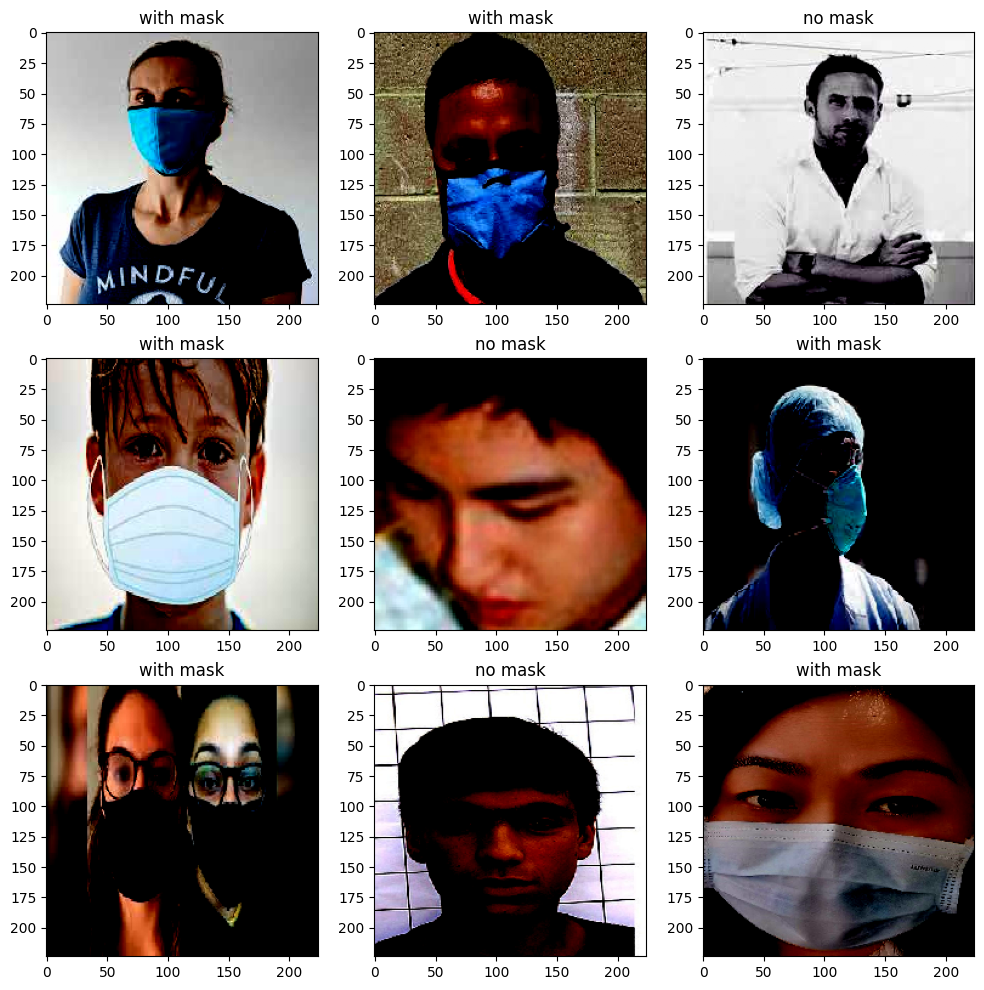

In [4]:


fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        axes[i][j].imshow(train_x[i*3+j])
        if train_y[i*3+j]==0:
            axes[i][j].set_title("no mask")
        else:
            axes[i][j].set_title("with mask")
    
        

In [5]:
train_x = np.array(train_x, dtype="float32")
test_x = np.array(test_x , dtype="float32")
train_y = np.array(train_y)
test_y = np.array(test_y)





In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

image_gen = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.15,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
fill_mode="nearest")


baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))



/tmp/ipykernel_18/2606210330.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
for j in baseModel.layers:
    j.trainable=False

In [8]:
model = baseModel.output
model = tf.keras.layers.MaxPooling2D(pool_size=(5, 5))(model)
model = tf.keras.layers.Flatten(name="flatten")(model)
model = tf.keras.layers.Dense(128, activation="relu")(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(1, activation="sigmoid")(model)

model=tf.keras.Model(inputs=baseModel.input,outputs=model)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
from keras.callbacks import EarlyStopping
early_stopping =EarlyStopping(patience=4, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
image_gen.flow(train_x, train_y, batch_size=32),
steps_per_epoch=len(train_x) // 32,
validation_data=(test_x, test_y),
validation_steps=len(test_x) // 32,
epochs=15,callbacks=[early_stopping])


Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.8912 - loss: 0.3938 - val_accuracy: 0.9755 - val_loss: 0.0621
Epoch 2/15


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 219ms/step - accuracy: 0.9688 - loss: 0.0597 - val_accuracy: 0.9722 - val_loss: 0.0714
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9737 - loss: 0.0707 - val_accuracy: 0.9828 - val_loss: 0.0388
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 195ms/step - accuracy: 0.9375 - loss: 0.0455 - val_accuracy: 0.9828 - val_loss: 0.0377
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9808 - loss: 0.0581 - val_accuracy: 0.9835 - val_loss: 0.0416
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - accuracy: 0.9688 - loss: 0.0314 - val_accuracy: 0.9835 - val_loss: 0.0415
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.9868 - loss: 0.0415 - val_accuracy: 0.9881 - val_loss: 0.0344
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 219ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9881 - val_loss: 0.0345
Epoch 9/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9865 - loss: 0.0414 - val_accurac

In [10]:
predictions=model.predict(test_x)
predictions=predictions>0.5

48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 764ms/step


In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Text(0.5, 1.0, 'Confusion Matrix')

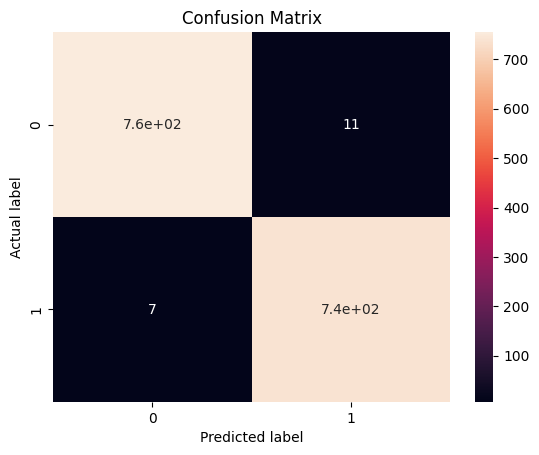

In [12]:
sns.heatmap(confusion_matrix(test_y,predictions),annot=True)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix')


In [13]:
model.save("mask_classifier.h5")